# ResNet50 /  Classify Multi-label Emotions

In [10]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 376.1 MB 13 kB/s 
time: 34.6 s (started: 2022-10-25 14:31:48 +00:00)


In [11]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 438 kB 34.6 MB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.18.0-cp37-cp37m-linux_x86_64.whl size=126872 sha256=ab71f282a68742e869589f45d067cd0824b15d41bb8e222e3a653189e1fec70a
  Stored in directory: /root/.cache/pip/wheels/09/72/ac/d233654aa46be315a8b91ba5c268476d42de920c6a58116219
Successfully built nvidia-dali-tf-plugin-cuda110
time: 10.8 s (started: 2022-10-25 14:32:22 +00:00)


In [15]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

time: 812 µs (started: 2022-10-25 14:42:07 +00:00)


In [16]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 879 µs (started: 2022-10-25 14:42:08 +00:00)


In [17]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.69 s (started: 2022-10-25 14:42:09 +00:00)


In [18]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 27.3 ms (started: 2022-10-25 14:42:11 +00:00)


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.35 s (started: 2022-10-25 14:42:13 +00:00)


### Load label data.

In [20]:
# Load labels, check headers, check data shape.
f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"

df_label = pd.read_csv(f_PATH+'label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv(f_PATH+'label/label_multi-label_valid.csv')
label_train = pd.read_csv(f_PATH+'label/label_multi-label_train.csv')
label_test = pd.read_csv(f_PATH+'label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 162 ms (started: 2022-10-25 14:42:15 +00:00)


### Define training pipeline.

In [21]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_train.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 3.2 ms (started: 2022-10-25 14:42:24 +00:00)


### Define validation pipeline.

In [22]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_valid.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 14.3 ms (started: 2022-10-25 14:42:33 +00:00)


### Fine-tune ResNet50 model for classifying multi-label emotions.

In [23]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/guides/transfer_learning/

if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)       

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)      

        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid         
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 24
        
        base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
            include_top=False, # Do not include the ImageNet classifier at the top.
            pooling='avg') # average pooling added 
        
        base_model.trainable = True   # Unfreeze ResNet50 weights.

        # See how many layers are in the base model.
        print("Number of layers in the base model: ", len(base_model.layers))
        
        # Fine-tune from this layer onwards.
        fine_tune_at = 120
        
        # Freeze all the layers before the `fine_tune_at` layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False   
            
        inputs = keras.Input(shape=(64, 64, 3))
        x = base_model(inputs)
        fc1 = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer)(x)        
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)          
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1)   
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)  
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback])

Number of layers in the base model:  176
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 24)                49176     
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
Total params: 23,637,488
Trainable params: 17,265,264
Non-trainable params: 6,372,224
________________________________________________________________

In [24]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 1.1 ms (started: 2022-10-25 15:07:38 +00:00)


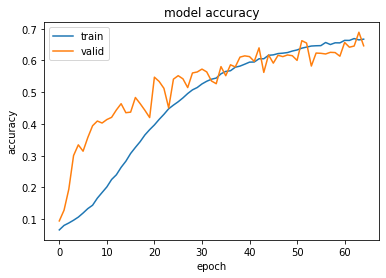

time: 201 ms (started: 2022-10-25 15:07:38 +00:00)


In [25]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

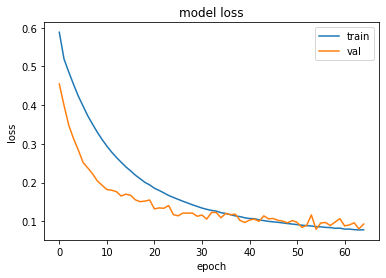

time: 130 ms (started: 2022-10-25 15:07:38 +00:00)


In [26]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [27]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_test.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.67 ms (started: 2022-10-25 15:07:38 +00:00)


### Check test data accuracy.

In [28]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 24), dtype=tf.int64, name=None))>
3882/3882 [==============================] - 39s 10ms/step - loss: 0.0764 - accuracy: 0.6321
Test accuracy: 0.6321483850479126
5/5 [==============================] - 1s 8ms/step
A test output from the last layer: [1.8850811e-05 4.4450153e-06 6.3102220e-06 7.7786943e-05 6.2306155e-03
 2.5630757e-04 2.5862901e-04 5.7628404e-05 2.8852036e-02 7.8578341e-05
 3.6686775e-05 1.1269171e-02 9.8540986e-01 6.0316100e-04 1.2607007e-05
 1.2619129e-03 2.7821554e-05 1.1270105e-04 4.6661804e-05 2.1684944e-05
 6.6094421e-05 9.0348831e-06 1.6688922e-05 1.6220276e-06]
Index of the maximum value: 12
Label: upset
time: 39.9 s (started: 2022-10-25 15:07:38 +00:00)


In [29]:
predictions

array([[1.88508111e-05, 4.44501529e-06, 6.31022203e-06, 7.77869427e-05,
        6.23061555e-03, 2.56307569e-04, 2.58629007e-04, 5.76284037e-05,
        2.88520362e-02, 7.85783413e-05, 3.66867753e-05, 1.12691708e-02,
        9.85409856e-01, 6.03160996e-04, 1.26070072e-05, 1.26191287e-03,
        2.78215539e-05, 1.12701047e-04, 4.66618039e-05, 2.16849439e-05,
        6.60944206e-05, 9.03488308e-06, 1.66889222e-05, 1.62202764e-06],
       [4.76795575e-03, 3.75913153e-03, 4.71891789e-03, 6.05097460e-03,
        3.72028798e-02, 9.88722593e-02, 2.48697796e-03, 2.59876288e-02,
        1.62589327e-01, 3.64088034e-03, 3.01458128e-03, 2.25162163e-01,
        1.35309756e-01, 1.82077056e-03, 1.58840220e-03, 1.53778061e-01,
        1.61056016e-02, 1.14731062e-02, 6.62148523e-04, 1.28204585e-03,
        2.57427432e-03, 1.22245855e-03, 1.44044152e-02, 4.24800208e-03],
       [4.43286059e-04, 6.05816138e-04, 6.84159284e-04, 3.79985053e-04,
        4.40864600e-02, 2.09028553e-03, 7.84082571e-04, 2.6436

time: 7.93 ms (started: 2022-10-25 15:08:18 +00:00)


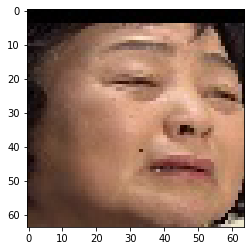

time: 165 ms (started: 2022-10-25 15:08:18 +00:00)


In [30]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [31]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 7.96 ms (started: 2022-10-25 15:08:18 +00:00)


### Result: Argmax Accuracy & Micro F1-score

In [32]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

3882/3882 [==============================] - 30s 8ms/step
time: 31.1 s (started: 2022-10-25 15:08:18 +00:00)


In [33]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 2.12 s (started: 2022-10-25 15:08:49 +00:00)


In [34]:
true_test.shape

(3882, 24)

time: 7.14 ms (started: 2022-10-25 15:08:51 +00:00)


In [35]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.6321483771251932
f1_micro: 0.6321483771251932
time: 260 ms (started: 2022-10-25 15:08:51 +00:00)


### Result: Threshold=0.5 Accuracy & Micro F1-score

In [36]:
pred_05 = pred_test.copy()
pred_05

array([[1.8850811e-05, 4.4450153e-06, 6.3102220e-06, ..., 9.0348831e-06,
        1.6688922e-05, 1.6220276e-06],
       [4.7679557e-03, 3.7591315e-03, 4.7189179e-03, ..., 1.2224586e-03,
        1.4404415e-02, 4.2480021e-03],
       [4.4328606e-04, 6.0581614e-04, 6.8415928e-04, ..., 8.9023779e-05,
        1.0120205e-03, 1.4729201e-03],
       ...,
       [2.5515470e-03, 5.1313365e-04, 3.4726367e-04, ..., 1.3772034e-05,
        3.0630266e-03, 1.7494539e-04],
       [1.4876614e-02, 6.7027193e-01, 9.0013966e-02, ..., 1.4629274e-02,
        6.9321091e-03, 1.9515920e-02],
       [2.8410621e-04, 6.3848851e-04, 1.7156861e-04, ..., 8.3060215e-05,
        2.7399892e-03, 9.4037480e-04]], dtype=float32)

time: 7.38 ms (started: 2022-10-25 15:08:52 +00:00)


In [37]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.05 s (started: 2022-10-25 15:08:52 +00:00)


In [38]:
accuracy_score(true_test, pred_05)

0.5265327150953117

time: 20 ms (started: 2022-10-25 15:08:53 +00:00)


In [39]:
f1_score(true_test, pred_05, average='micro')

0.7438734360459103

time: 20.2 ms (started: 2022-10-25 15:08:53 +00:00)


### Result: Threshold=0.4 Accuracy & Micro F1-score

In [40]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.13 s (started: 2022-10-25 15:08:53 +00:00)


In [41]:
accuracy_score(true_test, pred_04)

0.5839773312725399

time: 13.3 ms (started: 2022-10-25 15:08:54 +00:00)


In [42]:
f1_score(true_test, pred_04, average='micro')

0.7767524052621244

time: 21.5 ms (started: 2022-10-25 15:08:54 +00:00)


### Result: Threshold=0.3 Accuracy & Micro F1-score

In [43]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.21 s (started: 2022-10-25 15:08:54 +00:00)


In [44]:
accuracy_score(true_test, pred_03)

0.6326635754765585

time: 15.4 ms (started: 2022-10-25 15:08:55 +00:00)


In [45]:
f1_score(true_test, pred_03, average='micro')

0.8007424593967518

time: 17 ms (started: 2022-10-25 15:08:55 +00:00)


### Result: Threshold=0.2 Accuracy & Micro F1-score

In [46]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.34 s (started: 2022-10-25 15:08:55 +00:00)


In [47]:
accuracy_score(true_test, pred_02)

0.6439979392065945

time: 13.1 ms (started: 2022-10-25 15:08:57 +00:00)


In [48]:
f1_score(true_test, pred_02, average='micro')

0.7976868781358959

time: 25.1 ms (started: 2022-10-25 15:08:57 +00:00)


### Result: Threshold=0.1 Accuracy & Micro F1-score

In [49]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.62 s (started: 2022-10-25 15:08:57 +00:00)


In [50]:
accuracy_score(true_test, pred_01)

0.5316846986089645

time: 11.6 ms (started: 2022-10-25 15:08:58 +00:00)


In [51]:
f1_score(true_test, pred_01, average='micro')

0.7335043465868606

time: 21.1 ms (started: 2022-10-25 15:08:58 +00:00)
